In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from datetime import datetime

In [2]:
#read data
#data is from https://www.kaggle.com/datasets/bcheong/ut-austin-employee-salaries-and-home-locations
raw_data = pd.read_csv("utaustin_locations_jobs.csv")

In [3]:
raw_data

,anonymous_key,job,dept,salary,latitude,longitude,hire_date,race,gender,type,address
0,1,Head Coach ...,INTERCOLLEGIATE ATHLETICS,3040417,30.30098,-97.78031,20150406,BLACK ...,MALE,FULL TIME,"2101 Matthews Dr, Austin, TX 78703"
1,2,Head Coach ...,INTERCOLLEGIATE ATHLETICS,2746220,29.69439,-95.47546,19990119,WHITE ...,MALE,FULL TIME,"5221 Pine St, Bellaire, TX 77401"
2,3,Professor (Medical Affiliated) ...,DEPARTMENT OF SURGERY AND PERIOPERATIVE CARE,969500,30.31174,-97.79023,20150323,WHITE ...,MALE,FULL TIME,"4360 River Garden Trail, Austin, TX 78746"
3,4,Head Coach ...,INTERCOLLEGIATE ATHLETICS,880000,30.40765,-97.75845,19980715,WHITE ...,FEMALE,FULL TIME,"5708 Painted Valley Dr, Austin, TX 78759"
4,5,Athletic Director ...,INTERCOLLEGIATE ATHLETICS,850000,30.27964,-97.74249,20150916,WHITE ...,MALE,FULL TIME,"1616 Guadalupe St, Austin, TX 78701"
...,...,...,...,...,...,...,...,...,...,...,...
14003,14004,Specialist ...,SCHOOL OF LAW,1253,30.31010,-97.90093,19810901,WHITE ...,MALE,PART TIME,"10611 Indigo Broom Loop, Austin, TX 78733"
14004,14005,Lecturer ...,SCHOOL OF LAW,1253,30.25114,-97.78489,19830703,WHITE ...,FEMALE,PART TIME,"2700 Rockingham Dr, Austin, TX 78704"
14005,14006,Adjunct Professor ...,SCHOOL OF LAW,1253,30.26634,-97.80082,20070901,WHITE ...,MALE,PART TIME,"3108 Eanes Circle, Austin, TX 78746"
14006,14007,Specialist ...,SCHOOL OF LAW,1253,30.25268,-97.84564,19990505,WHITE ...,MALE,PART TIME,"5801 Travis Green Ln, Austin, TX 78735"


## Preprocessing

In [4]:
#check for nan values
raw_data.isna().values.any()
#remove nans not in location
data = raw_data.copy()
data = data[['job', 'dept', 'salary', 'hire_date', 'race', 'gender', 'type', 'address']]
data = data.dropna()

> __NB__: Der mangler koordinater for cirka 4000 observationer, så jeg har bare fjernet nan'er i de andre kategorier (kun en håndfuld rækker), som vi kan regne på - og så kan vi fjerne i koordinaterne, når vi når dertil. 

In [5]:
#remove white space
data["job"] = data["job"].str.strip()
data["dept"] = data["dept"].str.strip()
data["race"] = data["race"].str.strip()
data["gender"] = data["gender"].str.strip()
data["type"] = data["type"].str.strip()
data["address"] = data["address"].str.strip()

In [6]:
#remove small race categories
race2keep = data["race"].unique()[0:6]
data = data.loc[data["race"].isin(race2keep)]

In [7]:
#change time format to date time
data[['str_date']] = data[['hire_date']].applymap(str).applymap(lambda s: "{}/{}/{}".format(s[6:], s[4:6], s[0:4])) #to string

data["date_time"] = " "
for i in data.index:
    x = datetime.strptime(data['str_date'][i], '%d/%m/%Y') #to date time
    data["date_time"][i] = x
    
#### basically stjålet fra 
# https://stackoverflow.com/questions/43133605/convert-integer-yyyymmdd-to-date-format-mm-dd-yyyy-in-python

C:\Users\johan\AppData\Local\Temp/ipykernel_15548/975685634.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date_time"][i] = x


In [8]:
#get year and month
data['year_hire'] = pd.DatetimeIndex(data['date_time']).year
data['month'] = pd.DatetimeIndex(data['date_time']).month_name()
data['year_emp'] = 2018 - data['year_hire']

In [9]:
#get zip code 
data["zip"] = ""

for i in data.index:
    address = data["address"][i].split()
    data["zip"][i] = address[-1]
    
data = data.loc[data["zip"] != "-"]
data = data.loc[data["zip"] != "France"]

for i in data.index: 
    data["zip"][i] = int(data["zip"][i])

C:\Users\johan\AppData\Local\Temp/ipykernel_15548/2932893889.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["zip"][i] = address[-1]
C:\Users\johan\AppData\Local\Temp/ipykernel_15548/2932893889.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["zip"][i] = int(data["zip"][i])


## Employment (who works where)

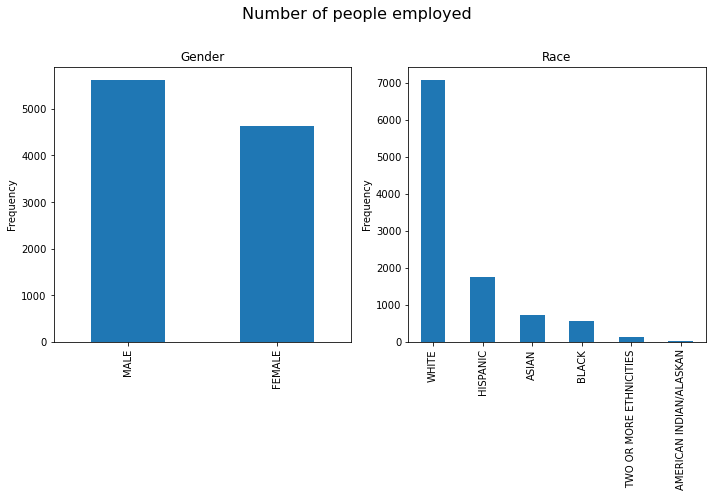

In [10]:
#general employment 
frequencies_emp_g = pd.value_counts(data["gender"])
frequencies_emp_r = pd.value_counts(data["race"])

fig = plt.figure(figsize = (10,7))
fig.suptitle('Number of people employed\n', size = 16)

plt.subplot(1,2,1)
frequencies_emp_g.plot(kind = "bar", title = "Gender", ylabel = "Frequency")

plt.subplot(1,2,2)
frequencies_emp_r.plot(kind = "bar", title = "Race", ylabel = "Frequency")
    
plt.tight_layout()

In [11]:
#keep only departments with at least 10 employed
dept2keep = []
data_dept = data.copy()
dept_size = data.groupby("dept").size().sort_values(ascending = False)

for i in data["dept"].unique(): 
    if(dept_size[i] > 9):
        dept2keep.append(i)
        
data_dept = data_dept.loc[data_dept["dept"].isin(dept2keep)]

## Yearly development in hiring

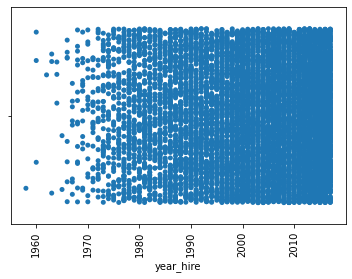

In [12]:
#when have people been employed
sns.stripplot(x="year_hire", hue="gender", data=data, jitter = 0.4)
plt.xticks(rotation = 90);

<AxesSubplot:xlabel='year_hire', ylabel='race'>

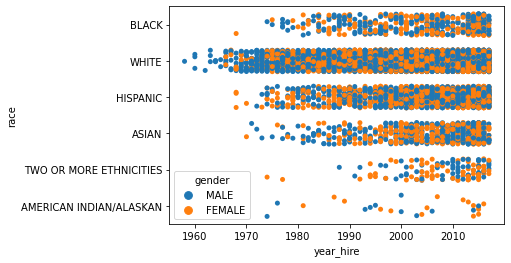

In [13]:
#jitter plot
sns.stripplot(x = "year_hire", y = "race", hue="gender", jitter = 0.3,  data=data)

> Ideen var at prøve at kigge på, hvornår folk er blevet ansat - om der fx er forskel i, hvilket køn man har anst i løbet af de sidste år

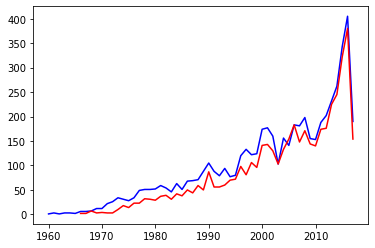

In [14]:
#how many people are hired every year?
hired_female = data.groupby(["gender","year_hire"]).size()["FEMALE"]
hired_male =  data.groupby(["gender","year_hire"]).size()["MALE"]

plt.plot(range(1960,2018), hired_male, color = "blue")
plt.plot(range(1966,2018), hired_female, color = "red")


## Salary: Who is payed what amount?

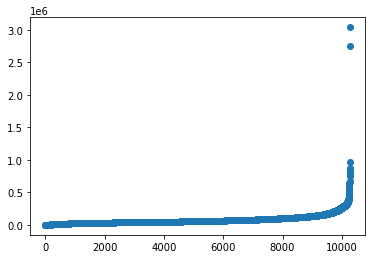

In [15]:
#salary overview 
np.min(data["salary"])
np.max(data["salary"])

salary_sort = data["salary"].sort_values(ascending = True)

plt.scatter(range(len(salary_sort.index)), salary_sort)

In [16]:
#mean salary gender
mean_salary_male = np.mean(data.loc[data["gender"] == "MALE"]["salary"])
mean_salary_female = np.mean(data.loc[data["gender"] == "FEMALE"]["salary"])

print("Mean salary (male)", mean_salary_male)
print("Mean salary (female)", mean_salary_female)

Mean salary (male) 89542.67697228145
Mean salary (female) 65864.7100387764


In [17]:
#mean salary race 
racetype = data["race"].unique()

for race in racetype: 
    mean_salary_race = np.mean(data.loc[data["race"] == race]["salary"])
    print("Mean salary ("+race+")", mean_salary_race)

Mean salary (BLACK) 68541.72043010753
Mean salary (WHITE) 85442.49342941925
Mean salary (HISPANIC) 53682.60091743119
Mean salary (ASIAN) 86276.60219478738
Mean salary (TWO OR MORE ETHNICITIES) 61246.92592592593
Mean salary (AMERICAN INDIAN/ALASKAN) 73367.77777777778


In [18]:
#salary quartiles 
lq, mq, uq = np.quantile(data["salary"],[0.25,0.5,0.75])

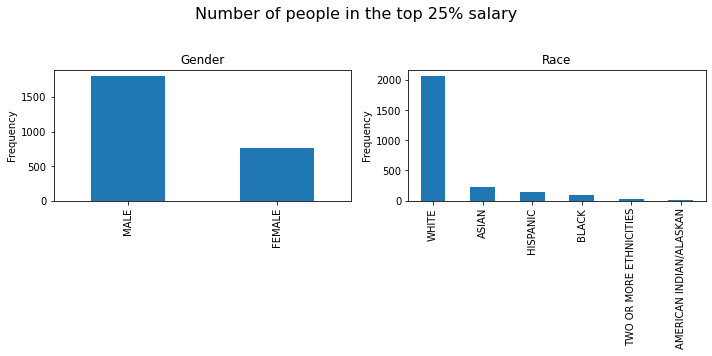

In [19]:
#who is working the 25% highest paying jobs? 
high_pay = data[data["salary"] > uq]
frequencies_pay_g = pd.value_counts(high_pay["gender"])
frequencies_pay_r = pd.value_counts(high_pay["race"])

#figure
fig = plt.figure(figsize = (10,5))
fig.suptitle('Number of people in the top 25% salary\n', size = 16)

plt.subplot(1,2,1)
frequencies_pay_g.plot(kind = "bar", title = "Gender", ylabel = "Frequency")

plt.subplot(1,2,2)
frequencies_pay_r.plot(kind = "bar", title = "Race", ylabel = "Frequency")
    
plt.tight_layout()

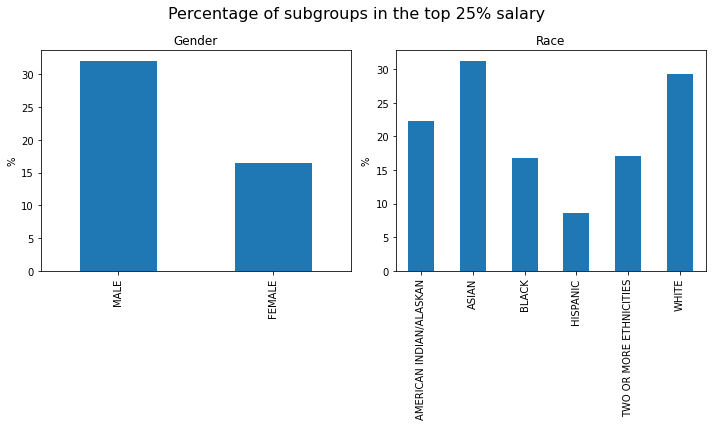

In [20]:
#percentage of subgroups that work the 25% highest paying jobs
paygap_g = frequencies_pay_g/frequencies_emp_g*100
paygap_r = frequencies_pay_r/frequencies_emp_r*100

#figure
fig = plt.figure(figsize = (10,6))
fig.suptitle('Percentage of subgroups in the top 25% salary', size = 16)

plt.subplot(1,2,1)
paygap_g.plot(kind = "bar", title = "Gender",ylabel = "%")

plt.subplot(1,2,2)
paygap_r.plot(kind = "bar", title = "Race", ylabel = "%")

plt.tight_layout()

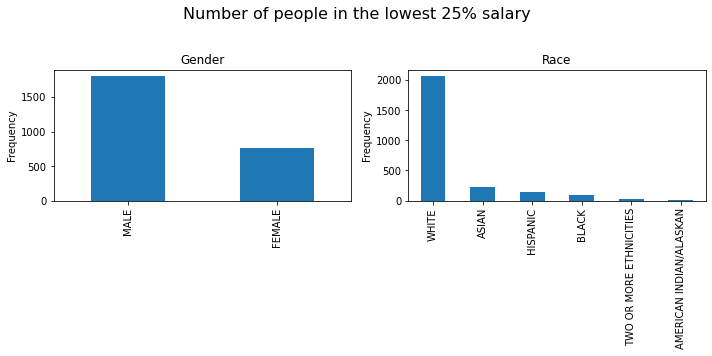

In [21]:
#who is working the 25% lowest paying jobs? 
low_pay = data[data["salary"] < lq]
frequencies_low_pay_g = pd.value_counts(low_pay["gender"])
frequencies_low_pay_r = pd.value_counts(low_pay["race"])

#figure
fig = plt.figure(figsize = (10,5))
fig.suptitle('Number of people in the lowest 25% salary\n', size = 16)

plt.subplot(1,2,1)
frequencies_pay_g.plot(kind = "bar", title = "Gender", ylabel = "Frequency")

plt.subplot(1,2,2)
frequencies_pay_r.plot(kind = "bar", title = "Race", ylabel = "Frequency")
    
plt.tight_layout()

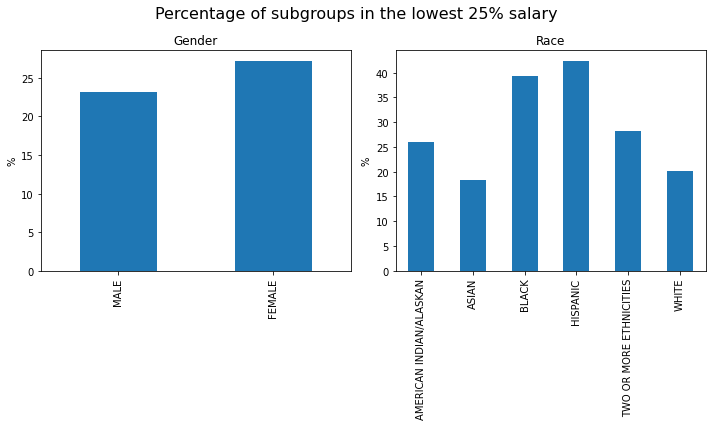

In [91]:
#percentage of subgroups that work the 25% lowest paying jobs
low_paygap_g = frequencies_low_pay_g/frequencies_emp_g*100
low_paygap_r = frequencies_low_pay_r/frequencies_emp_r*100

#figure
fig = plt.figure(figsize = (10,6))
fig.suptitle('Percentage of subgroups in the lowest 25% salary', size = 16)

plt.subplot(1,2,1)
low_paygap_g.plot(kind = "bar", title = "Gender",ylabel = "%")

plt.subplot(1,2,2)
low_paygap_r.plot(kind = "bar", title = "Race", ylabel = "%")

plt.tight_layout()

In [1]:
#are professors paid the same?
test = data[data["job"] == "Professor"]

#figure
fig = plt.figure(figsize = (15,10))
fig.suptitle('Boxplot: Salary for professors', size = 16)

plt.subplot(1,2,1)
ax = sns.boxplot(x="gender", y="salary", data=test)

plt.subplot(1,2,2)
plt.tight_layout()

NameError: name 'plt' is not defined

In [52]:
#t-test for gender
test_male = test.loc[test["gender"] == "MALE"]
test_female = test.loc[test["gender"] == "FEMALE"]

test_stat, p_val =scipy.stats.ttest_ind(test_female["salary"],test_male["salary"])
print("We get a p-value of ",p_val," which means that we can reject the null hypothesis (i.e. equal pay between male and female professors) on a 99% confidence interval.")

We get a p-value of  0.00022885051197265145  which means that we can reject the null hypothesis (i.e. equal pay between male and female professors) on a 99% confidence interval.


In [25]:
data["race"].unique()

array(['BLACK', 'WHITE', 'HISPANIC', 'ASIAN', 'TWO OR MORE ETHNICITIES',
       'AMERICAN INDIAN/ALASKAN'], dtype=object)

In [26]:
#t-test for race
test_white = test.loc[test["race"] == "WHITE"]
test_hispanic = test.loc[test["race"] == "HISPANIC"]
test_asian = test.loc[test["race"] == "ASIAN"]
test_two = test.loc[test["race"] == "TWO OR MORE ETHNICITIES"]
test_afram = test.loc[test["race"] == "BLACK"]
test_indal = test.loc[test["race"] == "AMERICAN INDIAN/ALASKAN"]

test_stat1, p_val1 =scipy.stats.ttest_ind(test_white["salary"],test_hispanic["salary"])
test_stat2, p_val2 =scipy.stats.ttest_ind(test_white["salary"],test_asian["salary"])
test_stat3, p_val3 =scipy.stats.ttest_ind(test_white["salary"],test_two["salary"])
test_stat4, p_val4 =scipy.stats.ttest_ind(test_white["salary"],test_afram["salary"])
test_stat5, p_val5 =scipy.stats.ttest_ind(test_white["salary"],test_indal["salary"])

print(p_val1)
print(p_val2)
print(p_val3)
print(p_val4)
print(p_val5)


0.14695581046791634
0.015014769126203096
0.7863047712599422
0.5079698377965618
0.46162237958775654


In [27]:
#for the top ten most occupied jobs
#are men and wommen paid the same for the same job?
jobs = data.groupby("job").size().sort_values(ascending = False)[0:10].index

for i in jobs: 
    test = data[data["job"] == i]
    test_male = test.loc[test["gender"] == "MALE"]
    test_female = test.loc[test["gender"] == "FEMALE"]
    
    test_stat, p_val =scipy.stats.ttest_ind(test_female["salary"],test_male["salary"])
    print(i)
    print("pval: ", p_val)

Professor
pval:  0.004119814480602131
Lecturer
pval:  0.3264947232888007
Associate Professor
pval:  0.008277848803178698
Administrative Associate
pval:  0.20350305442555994
Senior Administrative Associate
pval:  0.4167959249234392
Assistant Professor
pval:  0.0020357837111044373
Building Attendant II
pval:  0.0002213988637952015
Research Associate
pval:  5.2781900629523537e-05
Postdoctoral Fellow
pval:  0.14812723752519324
Administrative Assistant
pval:  0.29574604037840757


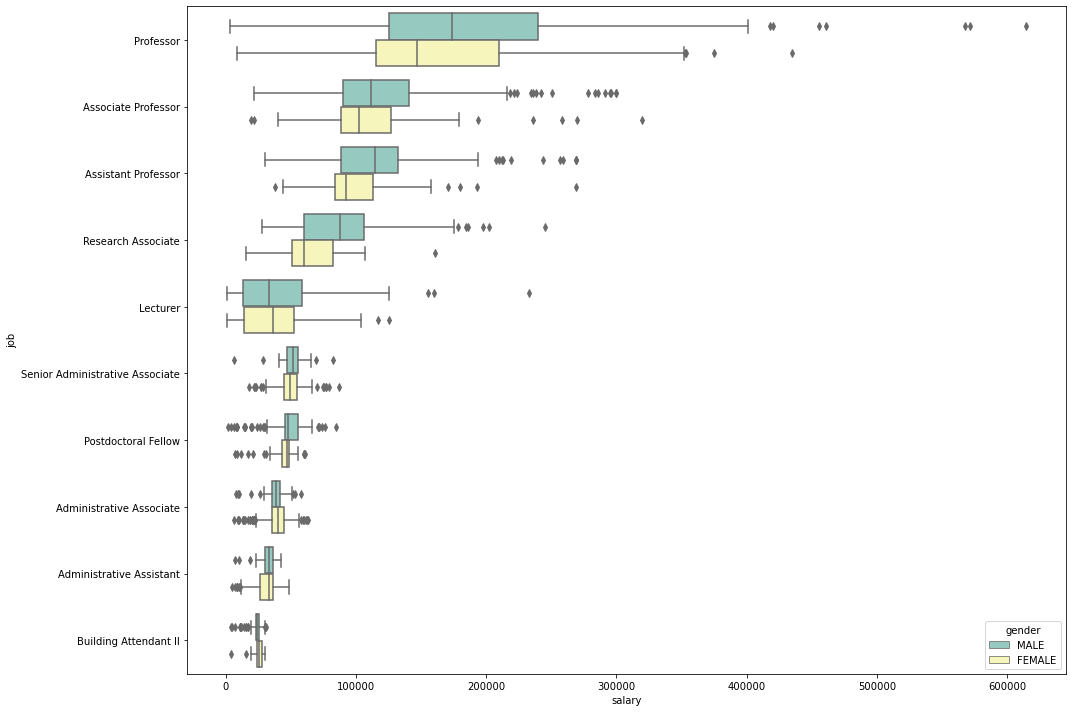

In [28]:
#boxplot
temp = data[data["job"].isin(jobs)]

#figure
fig = plt.figure(figsize = (15,10))

sns.boxplot(x="salary", y="job", hue="gender",
                 data=temp, palette="Set3")

plt.tight_layout()

In [53]:
race2keep

array(['BLACK', 'WHITE', 'HISPANIC', 'ASIAN', 'TWO OR MORE ETHNICITIES',
       'AMERICAN INDIAN/ALASKAN'], dtype=object)

In [ ]:
#for the top ten most occupied jobs
#are races paid the same for the same job?
jobs = data.groupby("job").size().sort_values(ascending = False)[0:10].index

for i in jobs: 
    test = data[data["job"] == i]
    test_black = test.loc[test["gender"] == "BLACK"]
    test_white = test.loc[test["gender"] == "WHITE"]
    test_hispanic = test.loc[test["gender"] == "HISPANIC"]
    test_asian = test.loc[test["gender"] == "ASIAN"]
    test_two = test.loc[test["gender"] == "TWO OR MORE ETHNICITIES"]
    test_indian = test.loc[test["gender"] == "AMERICAN INDIAN/ALASKAN"]


        
    
    test_stat, p_val =scipy.stats.ttest_ind(test_female["salary"],test_male["salary"])
    print(i)
    print("pval: ", p_val)

In [ ]:
#boxplot
temp = data[data["job"].isin(jobs)]

#figure
fig = plt.figure(figsize = (15,10))

sns.boxplot(x="salary", y="job", hue="gender",
                 data=temp, palette="Set3")

plt.tight_layout()

## Salary groups

In [29]:
#5 different salary stages
q20, q40, q60, q80 = np.quantile(data["salary"],[0.20, 0.40,0.60,0.80])

In [30]:
#asssigning salary groups
data["salary_group"] = " "

for i in data.index:
    obs = data["salary"][i]
    if obs < q20: 
        data["salary_group"][i] = 5
    elif obs < q40:
        data["salary_group"][i] = 4
    elif obs < q60:
        data["salary_group"][i] = 3
    elif obs < q80:
        data["salary_group"][i] = 2
    else: 
        data["salary_group"][i] = 1

C:\Users\johan\AppData\Local\Temp/ipykernel_15548/470774881.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["salary_group"][i] = 1
C:\Users\johan\AppData\Local\Temp/ipykernel_15548/470774881.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["salary_group"][i] = 2
C:\Users\johan\AppData\Local\Temp/ipykernel_15548/470774881.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["salary_group"][i] = 3
C:\Users\johan\A

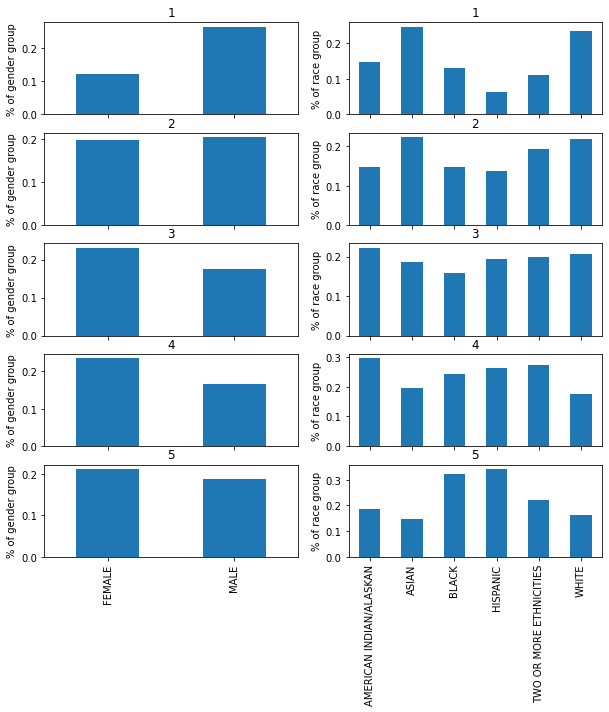

In [58]:
#plot race and sex for each salary group
plt.figure(figsize = (10,20))
plt.title("#crimes pr week by category")

for i in range(1,6): 
    plt.subplot(10,2,i*2-1)
    temp_sex = data[data["salary_group"] == i].groupby("gender").size()
    temp_sex_frac = temp_sex/data.groupby("gender").size()
    temp_sex_frac.plot(kind = "bar", xlabel = "", ylabel = "% of gender group", title = i)
    
    if(i < 5):
        plt.tick_params(labelbottom = False)
    
    plt.subplot(10,2,i*2)
    temp_race = data[data["salary_group"] == i].groupby("race").size()
    temp_race_frac = temp_race/data.groupby("race").size()
    temp_race_frac.plot(kind = "bar", xlabel = "", ylabel = "% of race group", title = i)
    
    if(i < 5):
        plt.tick_params(labelbottom = False)
    
#plt.tight_layout()

In [32]:
#extract districts 
group = data["salary_group"].unique()
group = sorted(group[0:5]) #remove nan and sort
total_emp = len(data) #denominator

#calculate P(C)
gender_list = data.groupby("gender").size() #numerator
p_C_g = gender_list/total_emp

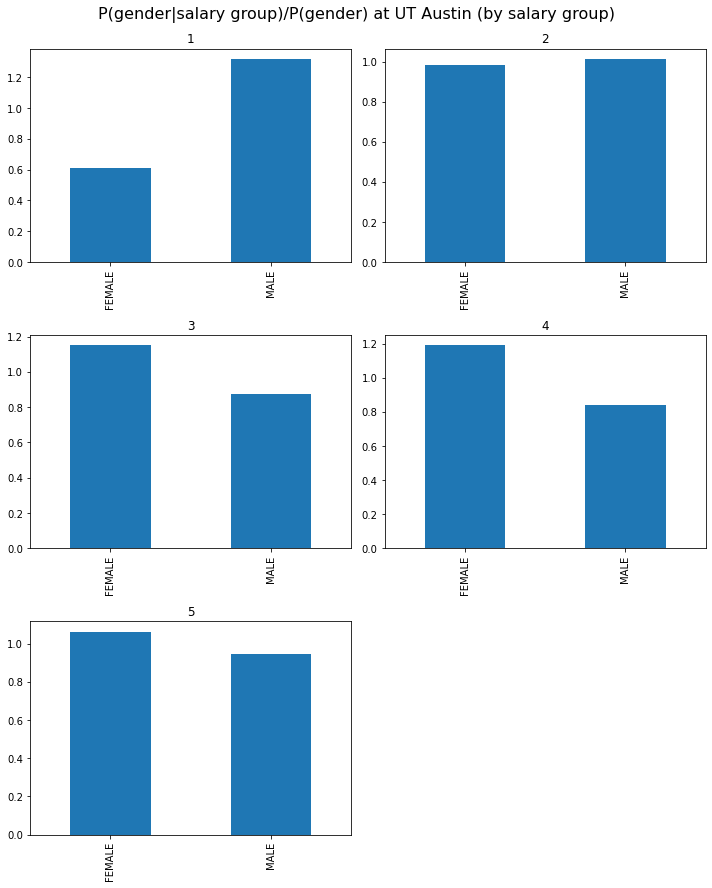

In [33]:
#calculate and plot P(C|D)/P(C)
fig = plt.figure(figsize=(10,20))
fig.suptitle('P(gender|salary group)/P(gender) at UT Austin (by salary group)\n', size = 16)

for i in enumerate(group):
    plt.subplot(5,2,i[0]+1)
    data_temp = data[data["salary_group"] == i[1]]
    gender_group = data_temp.groupby("gender").size()
    total_gender_group = len(data_temp)
    p_CD_g = gender_group/total_gender_group
    p = p_CD_g/p_C_g
    
    p.plot(kind = "bar", xlabel = "", ylabel = "", title = i[1])
    
plt.tight_layout()

In [34]:
#calculate P(C)
race_list = data.groupby("race").size() #numerator
p_C_r = race_list/total_emp

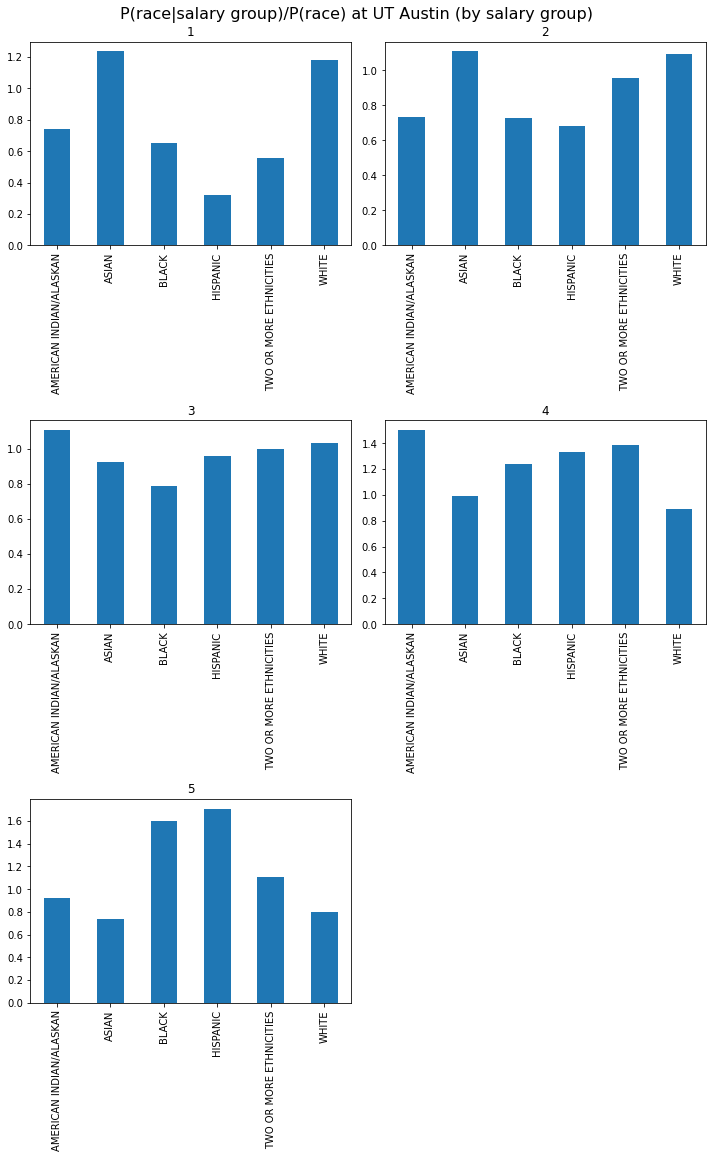

In [35]:
#calculate and plot P(C|D)/P(C)
fig = plt.figure(figsize=(10,25))
fig.suptitle('P(race|salary group)/P(race) at UT Austin (by salary group)\n', size = 16)

for i in enumerate(group):
    plt.subplot(5,2,i[0]+1)
    data_temp = data[data["salary_group"] == i[1]]
    race_group = data_temp.groupby("race").size()
    total_race_group = len(data_temp)
    p_CD_r = race_group/total_race_group
    p = p_CD_r/p_C_r
    
    p.plot(kind = "bar", xlabel = "", ylabel = "", title = i[1])
    
plt.tight_layout()

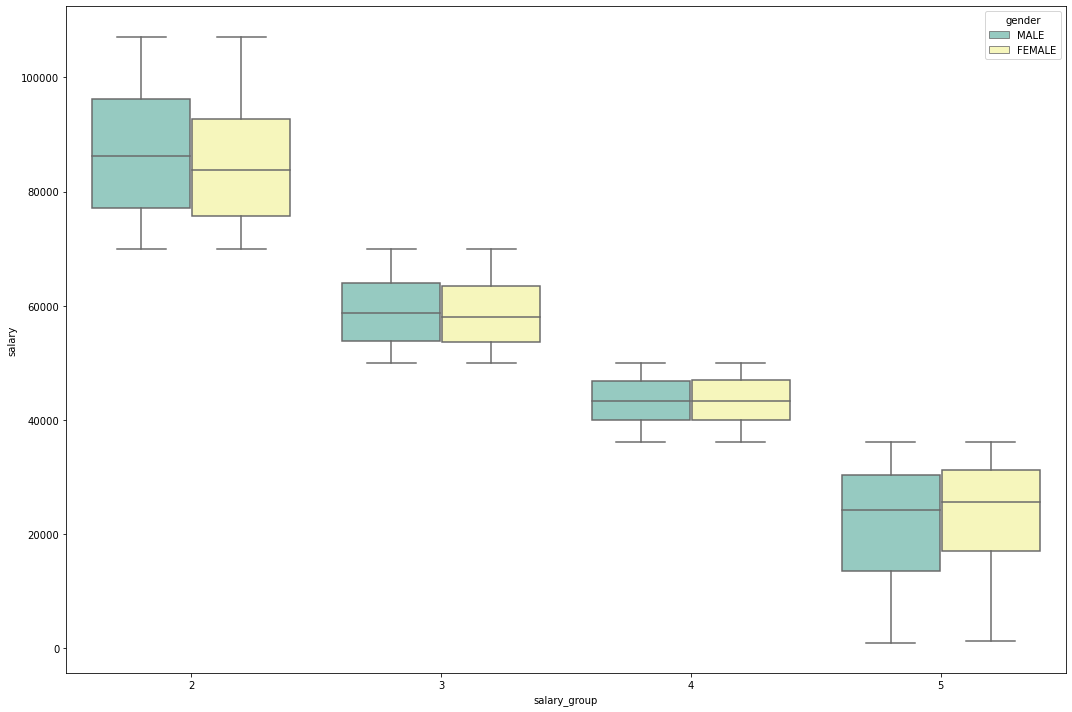

In [36]:
group1 = data[data["salary_group"] != 1]

temp = group1[group1["salary"] < 2000000]

#figure
fig = plt.figure(figsize = (15,10))

sns.boxplot(x="salary_group", y="salary", hue="gender",
                 data=temp, palette="Set3")

plt.tight_layout()

In [37]:
#for the top ten most occupied jobs
#are men and wommen paid the same for the same job?

for i in range(1,6): 
    test = data[data["salary_group"] == i]
    test_male = test.loc[test["gender"] == "MALE"]
    test_female = test.loc[test["gender"] == "FEMALE"]
    
    test_stat, p_val =scipy.stats.ttest_ind(test_female["salary"],test_male["salary"])
    print(i)
    print("pval: ", p_val)

1
pval:  3.376955985402849e-05
2
pval:  4.4945823875235284e-05
3
pval:  0.3676817267227317
4
pval:  0.4827008441192041
5
pval:  0.00022885051197265145


## Salary: Difference in employment time and location

Text(0, 0.5, 'Salary')

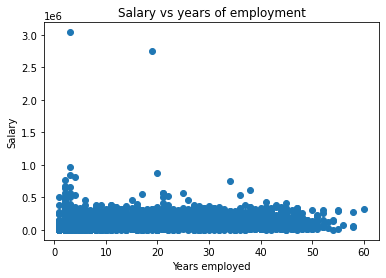

In [38]:
#do you get payed more or less depending on when you were employed?
plt.scatter(data["year_emp"],data["salary"])
plt.title("Salary vs years of employment")
plt.xlabel("Years employed")
plt.ylabel("Salary")

In [39]:
colors[0]

C:\Users\johan\anaconda3\lib\site-packages\IPython\core\magics\basic.py:343: UserWarning: Error changing shell color schemes.
The 'colors' trait of a ZMQInteractiveShell instance expected any of ['Neutral', 'NoColor', 'LightBG', 'Linux'] (case-insensitive), not the str '[0]'.
  color_switch_err('shell')
C:\Users\johan\anaconda3\lib\site-packages\IPython\core\magics\basic.py:350: UserWarning: Error changing exception color schemes.
Unrecognized color scheme: [0]
Valid schemes: ['NoColor', 'Linux', 'LightBG', 'Neutral', '']
  color_switch_err('exception')
C:\Users\johan\anaconda3\lib\site-packages\IPython\core\magics\basic.py:357: UserWarning: Error changing object inspector color schemes.
Unrecognized color scheme: [0]
Valid schemes: ['NoColor', 'Linux', 'LightBG', 'Neutral', '']
  color_switch_err('object inspector')


Text(0, 0.5, 'Salary')

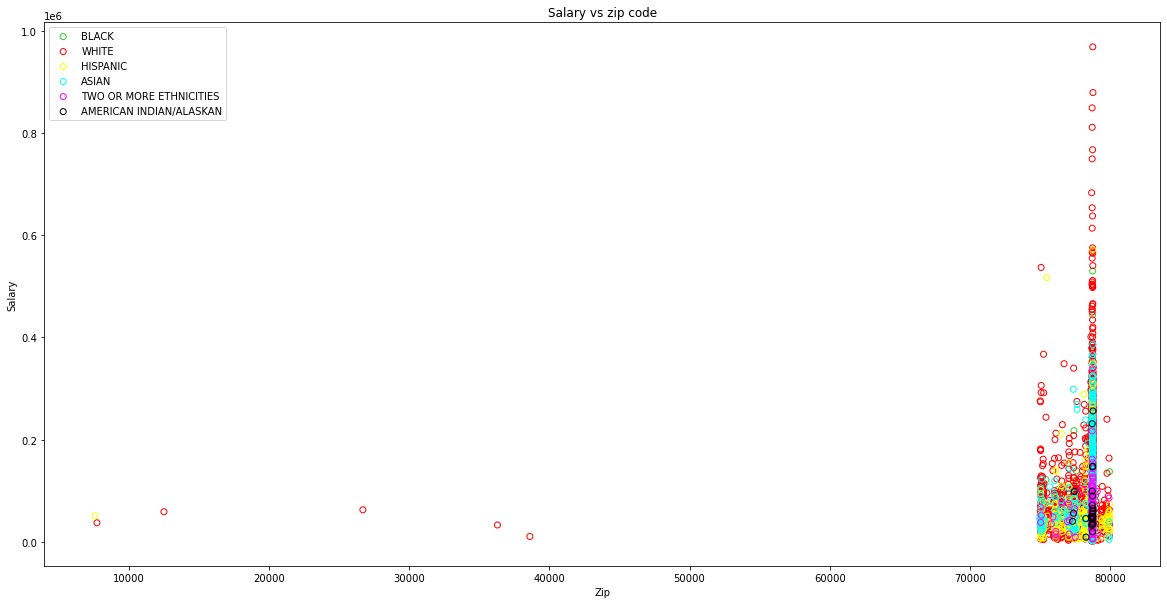

In [40]:
#correlation between salary and zip
plt.figure(figsize= (20,10))

colors = ["limegreen", "red", "yellow", "aqua", "magenta", "black"]

for i in range(0,6):
    data_outlier = data.loc[data["salary"] < 1500000]
    race_data = data_outlier.loc[data_outlier["race"] == race2keep[i]]
    plt.scatter(race_data["zip"],race_data["salary"], facecolors='none', edgecolors = colors[i])

plt.title("Salary vs zip code")
plt.xlabel("Zip")
#plt.xticks([], [])
plt.legend(race2keep)
#plt.col
plt.ylabel("Salary")

In [41]:
#different zip codes
np.sort(data["zip"].unique());

In [93]:
#number of kilometers from university
#se her: #https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
import geopy.distance
data_distance = raw_data.copy()
data_distance = data_distance.dropna()

data_distance["salary_group"] = " "
        
for i in data_distance.index:
    obs = data_distance["salary"][i]
    if obs < q20: 
        data_distance["salary_group"][i] = 5
    elif obs < q40:
        data_distance["salary_group"][i] = 4
    elif obs < q60:
        data_distance["salary_group"][i] = 3
    elif obs < q80:
        data_distance["salary_group"][i] = 2
    else: 
        data_distance["salary_group"][i] = 1
data_distance = data_distance[data_distance['address'].str.contains('TX')]


data_distance["distance"] = " "

coords_uni = (30.266666, -97.733330) #university

for i in data_distance.index: 
    coords_home = (data_distance["latitude"][i], data_distance["longitude"][i])
    data_distance["distance"][i] = geopy.distance.distance(coords_uni, coords_home).km

C:\Users\johan\AppData\Local\Temp/ipykernel_15548/1545829778.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distance["salary_group"][i] = 1
C:\Users\johan\AppData\Local\Temp/ipykernel_15548/1545829778.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distance["salary_group"][i] = 2
C:\Users\johan\AppData\Local\Temp/ipykernel_15548/1545829778.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_distance["salary_g

(0.0, 1000.0)

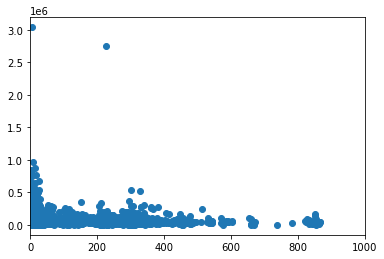

In [88]:
#plot: kilometers vs salary
plt.scatter(data_distance["distance"],data_distance["salary"])
plt.xlim(0,1000)

In [89]:
#data["distance"] = data_distance["distance"]
for i in range(1,6): 
    temp = data_distance.loc[data_distance["salary_group"] == i]
    print("The mean distance in salary group", i)
    print(np.mean(temp["distance"]))

The mean distance in salary group 1
25.438387893517294
The mean distance in salary group 2
37.24906205313029
The mean distance in salary group 3
41.31314680121382
The mean distance in salary group 4
59.681693609263306
The mean distance in salary group 5
64.67463121748361


In [85]:
data_distance["salary_group"].unique()

array([1, 2, 3, 4, 5], dtype=object)

<AxesSubplot:xlabel='salary_group', ylabel='distance'>

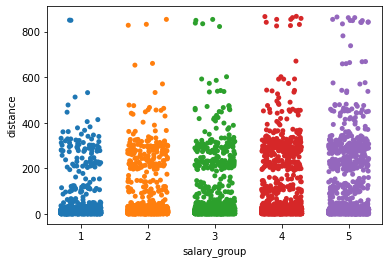

In [86]:
#jitter plot
sns.stripplot(x = "salary_group", y = "distance", jitter = 0.3,  data=data_distance)

## Average zip income model 

In [44]:
#import zip data
#from http://zipatlas.com/us/tx/zip-code-comparison/median-household-income.19.htm
zip_data = pd.read_excel("zip-data.xlsx")

In [45]:
#take out only relevant zip codes
unique_zip = data["zip"].unique()
data_zip = zip_data.loc[zip_data["zip"].isin(unique_zip)].reset_index(drop = True)

#change data_zip[avg] to int
for i in range(data_zip.shape[0]): 
    a = data_zip["avg_income"][i][1:].replace(',','')
    data_zip["avg_income"][i] = int(float(a))

C:\Users\johan\AppData\Local\Temp/ipykernel_15548/3374189213.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_zip["avg_income"][i] = int(float(a))


In [46]:
#add avg zip to data 
data["avg"] = 0
for i in range(data_zip.shape[0]):
    data["avg"] = np.where(data['zip'] == data_zip["zip"][i], data_zip["avg_income"][i], data["avg"])

In [47]:
#classify as higher or lower income than average
data["class_zip"] = (data["salary"] > data["avg"])*1

In [ ]:
#import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

## Diverse

## Overblik: Det har vi kigget på 
* Hvordan er fordelingen (generelt) i ansættelse? (køn/race)
* Hvor meget bliver mænd (i gennemsnit) betalt? Kvinder? Forskellige racer? 
* (Hvornår er folk blevet ansat? Forskelle i køn og race?)
* 10 hyppigste job: hvem arbejder der?(fordelt på race)

## Idéer til fortsat arbejde 
__Praktisk__
* Udvælg hvilke arbejdstyper, vi kigger på
* Samle departments i grupper 
* (DONE)Hent postnummer ud af adresse
* (DONE)Kolonne med antal ansættelsesår
* (DONE)Fjern white space i racer
* (DONE)Fjern white space i jobs

__Undersøgelse__
* Hvem er ansat full time og part time?
* "Ranke" jobs efter hvor meget man bliver betalt og undersøge, hvor folk er ansat (fx ud fra boxplots for løn? Eller andel af betalingsgruppe, der er udgjort af en bestemt undergruppe, som et bokeh plot) 
* Hvad arbejder forskellige folk med? I hvilke afdelinger? 
* Hvor bor folk henne? Geoplot (plot også universitetet)
* Model til forudsigelse: fx regression for løn? Eller klassifikation for jobtype?
* Betaler de samme jobs ens for race og køn?'
* Korrelation mellem salary og postnummer
* Udvikling i ansættelser over tid